# Implementation Notes
1. kind of A2C with target notwork -> 4 networks are used

`target network`란? <br><br>
on-policy method를 사용하면서 policy나 Q-function을 실시간으로 업데이트하면
training와중에 q함수가 계속 바뀌게 되고, 그러면 tranining stability에 좋지 않은 영향을 끼친다.<br><br>
따라서 off-policy처럼 학습하는 네트워크와 행동하는 네트워크를 분리한 뒤
행동 네트워크가 산출한 action에 따라 행동하고, 업데이트는 학습 네트워크에 한다.
주기적으로 학습 네트워크를 행동 네트워크게 덮어씌워준다. (아니면 학습이 안되니까...)<br><br>
이때 행동 네트워크를 target network라고 부른다.<br><br>
DQN 눈문에서는 네트워크를 통으로 덮어씌웠는데, DDPG논문에서는 tau라는 값을 이용해서
tau만큼은 학습 네트워크를 반영하고, 1-tau만큼은 원래 네트워크를 반영하는 방식으로 soft update를 한다.

2. actor(policy) output is not pdf but parameterized action
3. needs noise to explore, remove it when testing (may apply other methods)<br>

# How to compute the gradient of actor net

1. replay memory에서 랜덤 샘플링
2. 해당 샘플에서, actor policy를 이용해 수행할 액션 결정
3. 해당 action을 critic에 넣고 값 산출
4. actor network parameter에 따라 gradient 계산<br>


# How to compute the gradient of critic net

1. replay buffer에서 샘플링
2. target actor를 이용해 새로운 상태에서의 action 산출
3. 해당 action들을 target critic에 밀어넣어 target y 얻음
4. 얻은 state, action을 critic에 넣고 target network의 gradient 계산<br>

코드를 보면서 뭔소린지 차근차근 이해해보도록 하자.

In [2]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import gym
from tqdm import tqdm

In [3]:
# ReplayBuffer 클래스
# 그냥 똑같다. 건너뛰셈

class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [4]:
#Critic 함수

class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512,
            name='critic', chkpt_dir='ddpg'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                    self.model_name+'_ddpg')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q

In [5]:
#Actor Network

class ActorNetwork(keras.Model):

    # init함수: pendulum 환경에서는 action이 왼쪽/오른쪽, 그리고 힘의 세기로 구성된다. (그냥 -1 ~ +1 사이 값을 가진다고 보면 됨)
    def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2, name='actor',
            chkpt_dir='ddpg'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                    self.model_name+'_ddpg')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)
        mu = self.mu(prob)

        return mu

In [6]:
class Agent:

    # init함수: actor net이 값 변화에 더 민감하기 때문에 
    # actor learning rate인 alpha값을 더 작게 설정
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,
                 gamma=0.99, n_actions=2, max_size=50000, tau=0.005,
                 fc1=400, fc2=300, batch_size=64, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise

        #최대최소 action parameter 결정
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        # 네트워크 세팅
        self.actor = ActorNetwork(n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(name='critic')
        self.target_actor = ActorNetwork(n_actions=n_actions,
                                        name='target_actor')
        self.target_critic = CriticNetwork(name='target_critic')

        #컴파일
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # init()에서 실행하는 첫번째 복사이니 tau=1 실행
        # learn에서는 self.tau로 반영
        self.update_network_parameters(tau=1) 

    #soft update
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        #행동 actor에서 weight 추출 후 tau 반영해 update(actor)
        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        #target network에서 weight 추출 후 tau 반영해 update(critic)
        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic.set_weights(weights)

    # store_transition wrapper
    # 깔끔하게 OOP를 하려면 이정도는 기본
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    #그냥 저장함수
    def save_models(self):
        #print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.critic.save_weights(self.critic.checkpoint_file)
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    #그냥 로드함수
    def load_models(self):
        try:
            print('... loading models ...')
            self.actor.load_weights(self.actor.checkpoint_file)
            self.target_actor.load_weights(self.target_actor.checkpoint_file)
            self.critic.load_weights(self.critic.checkpoint_file)
            self.target_critic.load_weights(self.target_critic.checkpoint_file)
        except:
            print('No Existing Model Found.')

    # action netowork와 noise에 따라 action결정
    # evaluate가 True이면 noise를 추가하지 않음(테스트니까)
    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        #print(actions)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions],
                                        mean=0.0, stddev=self.noise)

        # tanh는 -1~1값을 가져서 그럴 일이 없지만
        # noise때문에 action의 숫자가 적합한 범위를 초과할 수 있음
        # action값이 가능한 action값의 min/max를 초과할 경우 clip
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        # 하나의 action 반환
        # 근데 왜 이렇게 했지? 이럴거면 n_action 수만큼 output node를 설정할 필요가...
        # 알아봐주세요
        return actions[0]

    # 대망의 learn 함수
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        states  = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        # getting the gradient of critic net using target actor
        with tf.GradientTape() as tape:
            # 1. target actor(행동 actor)를 사용해 action 산출
            target_actions = self.target_actor(states_)

            # 2. target actor가 산출한 action의 value를 target critic을 이용해 산출
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)

            # 3. 학습 critic이 산출한 action의 value 산출
            critic_value = tf.squeeze(self.critic(states, actions), 1)

            # 4. target y 계산
            target = rewards + self.gamma*critic_value_*(1-done)

            # 5. critic loss 계산: for i in batches: sum (y[i]-Q[i])^2
            # 근데 loss계산할 때 1/n 곱하는건 은 엿바꿔먹었나?
            # 는 아니고 MSE 함수가 해주는듯(아마 그렇겠지. 'mean' square error니까)
            critic_loss = keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss,
                                                self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        # Actor loss
        # phil 영상에서 식이 좀 잘못됨
        # actor gain이 E[Q(s, mu(a))] 이지, actor gain gradient가 E[del Q(s, mu(a))]가 아님
        # 논문에 의하면 actor gain gradient는 E[del Q(s, mu(a)) * del mu(a)] 임
        # 근데 코드는 제대로 돼있음ㅋㅋ
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss) #rank 1 tensor에 담겨있는 loss들 평균내기

        actor_network_gradient = tape.gradient(actor_loss,
                                               self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))

        self.update_network_parameters()

In [7]:
#Utility function

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

C:\Users\diamo\AppData\Local\Temp\ipykernel_16132\980999492.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
  0%|          | 0/500 [00:00<?, ?it/s]

... loading models ...


C:\Users\diamo\anaconda3\envs\RLenvironment\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))
100%|██████████| 500/500 [12:07<00:00,  1.46s/it]


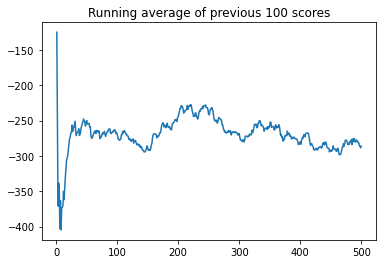

In [8]:
if __name__ == '__main__':
    env = gym.make('Pendulum-v1')
    agent = Agent(input_dims=env.observation_space.shape, env=env,
            n_actions=env.action_space.shape[0]) #여기서는 action space shape가 [2, 1] -> shape[0] 이용
    n_games = 500
    games_iter = tqdm(range(n_games))

    figure_file = 'plots/pendulum.png'

    best_score = env.reward_range[0]
    score_history = []

    # 학습을 하고 모델을 저장한 뒤 이 값을 true로 하면, 
    # model을 로딩하고 evaluation을 true로 바꿔서
    # test를 수행한다.
    load_checkpoint = True
    
    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation = env.reset()
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            n_steps += 1
        agent.learn()
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    for i in games_iter:
        observation = env.reset()
        done = False
        score = 0
        while not done:
            #print(observation)
            action = agent.choose_action(observation, evaluate)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, done)
            if not load_checkpoint:
                agent.learn()
            observation = observation_
            env.render()

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        #성과가 더 좋아지는 경우 모델 저장
        if avg_score > best_score:
            best_score = avg_score
            if not load_checkpoint:
                agent.save_models()

        #print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)

    #if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)